In [ ]:
%run ./Definitions.ipynb

In [2]:
!nvidia-smi
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "7"   # choose here your GPU (0-7)

import tensorflow as tf
import tensorflow.compat.v1 as tf
import keras
# from keras import backend as K
import tensorflow.python.keras.backend as K

Wed Dec 18 17:40:22 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 29%   39C    P2    56W / 250W |    284MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 29%   26C    P8     7W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

## Loading train data to use in Random Forest - union ground truth

In [4]:
tts_path = DATA_dir+'TrainTestVal/'
enc_df = pd.read_pickle(DATA_dir + 'enc_df.pkl')
y_train_df = pd.read_pickle(tts_path + 'yu_train.pkl')
y_val_df = pd.read_pickle(tts_path + 'yu_val.pkl')

#### Converting the labels to list and assign 0 label to non glaucoma (2 or 3 mismatch)

In [5]:
y_train = y_train_df['ClassLabel'].tolist()
y_val = y_val_df['ClassLabel'].tolist()

for i in range(len(y_train)):
    if(y_train[i] != 1):
        y_train[i] = 0
        
for i in range(len(y_val)):
    if(y_val[i] != 1):
        y_val[i] = 0


In [6]:
indices_train = np.load(tts_path + 'indices_train.npy')
indices_val = np.load(tts_path + 'indices_val.npy')
indices_test = np.load(tts_path + 'indices_test.npy')

In [7]:
enc_df.shape, len(y_train), len(y_val)

((85730, 6251), 51438, 17146)

## Class Distribution

#### No. of Glaucoma and non Glaucoma patients in training set

In [8]:
n_NG = 0
n_G = 0

for i in range(len(y_train)):
    if(y_train[i] == 1):
        n_G += 1
    else:
        n_NG += 1
        
print("No. of Glaucoma patients in training set:",n_G)
print("No. of non-Glaucoma patients in training set:",n_NG)

No. of Glaucoma patients in training set: 1358
No. of non-Glaucoma patients in training set: 50080


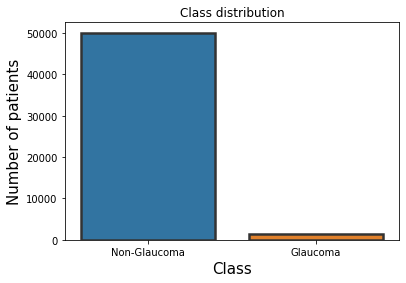

In [9]:
import seaborn as sns

class_name = ['Non-Glaucoma', 'Glaucoma']
count = [n_NG, n_G]
# plt.bar(class_name, count)
sns.barplot(x=class_name, y=count, linewidth=2.5, errcolor=".2", edgecolor=".2")
plt.xlabel('Class', fontsize=15)
plt.ylabel('Number of patients', fontsize=15)
plt.title('Class distribution')
plt.show()

## Assigning class weight for imbalance data set to use in Random forest classifier

In [10]:
class_weight = dict({0:1, 1:35})

## Feature Reduction and Saving Dataframe with reduced features

In [9]:
# cols2rem = ['87-','92-','135-','2227-','4689-','5181-','5326-','5327-','5945-','6119-','6148-','20002-','20008-','20009-','20010-','20011','20013-',
#             '20014-','40001-','40002-','41078-','41080-','41082-','41083-','41084-','41096-','41101-','41142-','41202-','41204-',
#             '41200-','41210-']

# # len(cols2rem) # 13
# remove_df  = enc_df.loc[:,enc_df.columns.str.startswith(cols2rem[0])]
# for i in range(1,len(cols2rem)):
#     remove_df = remove_df.join(enc_df.loc[:,enc_df.columns.str.startswith(cols2rem[i])])
    
# new_enc_df = enc_df.drop(remove_df.columns, axis=1)
# new_enc_df.shape

(85730, 4898)

### Spliting new_enc_df to train test val as per the indices

In [98]:
# meta_train = []
# meta_val = []
# meta_test = []

# for i in range(len(indices_train)):
#     meta_train.append(new_enc_df.iloc[indices_train[i]])
    
# for i in range(len(indices_val)):
#     meta_val.append(new_enc_df.iloc[indices_val[i]])
#     meta_test.append(new_enc_df.iloc[indices_test[i]])

# meta_train_arr = np.asarray(meta_train)
# meta_val_arr = np.asarray(meta_val)
# meta_test_arr = np.asarray(meta_test)

# meta_train_df = pd.DataFrame(meta_train_arr,columns = new_enc_df.columns)
# meta_val_df = pd.DataFrame(meta_val_arr,columns = new_enc_df.columns)
# meta_test_df = pd.DataFrame(meta_test_arr,columns = new_enc_df.columns)

In [100]:
# #SAVE - DONE
# meta_train_df.to_pickle(tts_path + 'reducedfeatures_meta_train.pkl')
# meta_val_df.to_pickle(tts_path + 'reducedfeatures_meta_val.pkl')
# meta_test_df.to_pickle(tts_path + 'reducedfeatures_meta_test.pkl')

### Loading Reduced Features Encodeded Metadata - Train and Validation

In [11]:
meta_train_df = pd.read_pickle(tts_path + 'reducedfeatures_meta_train.pkl')
meta_val_df = pd.read_pickle(tts_path + 'reducedfeatures_meta_val.pkl')

meta_train_df.shape, meta_val_df.shape, len(y_train), len(y_val)

((51438, 4898), (17146, 4898), 51438, 17146)

## RandomForestClassifier for Feature Importance

#### 1. Without class weights - everything is classified as majority class - High accuracy but 0 precision and recall

In [12]:
# # Random forest classifier
rfc_all = RandomForestClassifier(n_estimators = 40, min_samples_leaf = 3, max_features = 0.5, n_jobs=-1, oob_score = True)
rfc_all.fit(meta_train_df, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=0.5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
                       oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [13]:
# # Saving -- DONE !!
# from sklearn.externals import joblib
# joblib.dump(rfc_all, tts_path + 'RandomForest_allfeat_union.sav')

['/ds2/data/retina/UK_BB/patra/TrainTestVal/RandomForest_allfeat_union.sav']

In [14]:
rfc_all = joblib.load(tts_path + 'RandomForest_allfeat_union.sav')

#### 2. With class weights - giving higher weight to minority class

In [15]:
# rfc_all_cw = RandomForestClassifier(n_estimators = 40, min_samples_leaf = 3, max_features = 0.5, n_jobs=-1, oob_score = True)

rfc_all_cw = RandomForestClassifier(bootstrap=True,
                                    class_weight=class_weight, criterion='gini',
                                    max_depth=8, max_features='auto', max_leaf_nodes=None,
                                    min_impurity_decrease=0.0, min_impurity_split=None,
                                    min_samples_leaf=4, min_samples_split=10,
                                    min_weight_fraction_leaf=0.0, n_estimators=300,
                                    n_jobs=-1, oob_score=True,
                                    verbose=0, warm_start=False)

In [16]:
rfc_all_cw.fit(meta_train_df, y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 35},
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=4,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=300, n_jobs=-1, oob_score=True,
                       random_state=None, verbose=0, warm_start=False)

### Feature Dictionaries

In [17]:
# FEATURE DESCRIPTION DICTIONARY
feat_desc = pd.read_excel(DATA_dir + 'FeatureNames.xlsx')
feat_unique = feat_desc['UDI'].str.split('-',expand=True)[0].unique()
feat_desc_dict, feat_unique_dict = feature_desc()

In [18]:
feat_imp_dict, feat_unique_imp_dict = feature_imp(rfc_all_cw, meta_train_df)

In [19]:
pd.options.display.max_colwidth = 100

fi_red = get_imp_features(50)
display_all(fi_red)

,Features,Importance
0,"Intra-ocular pressure, corneal-compensated (right)",0.020554
1,Intra-ocular pressure device ID (left),0.018683
2,Age when attended assessment centre,0.018051
3,"Intra-ocular pressure, Goldmann-correlated (right)",0.017299
4,Year of birth,0.016431
5,"Intra-ocular pressure, Goldmann-correlated (left)",0.016391
6,Taking other prescription medications,0.015239
7,Corneal hysteresis (left),0.008786
8,Duration visual-acuity screen displayed (right),0.008594
9,Corneal hysteresis (right),0.006197


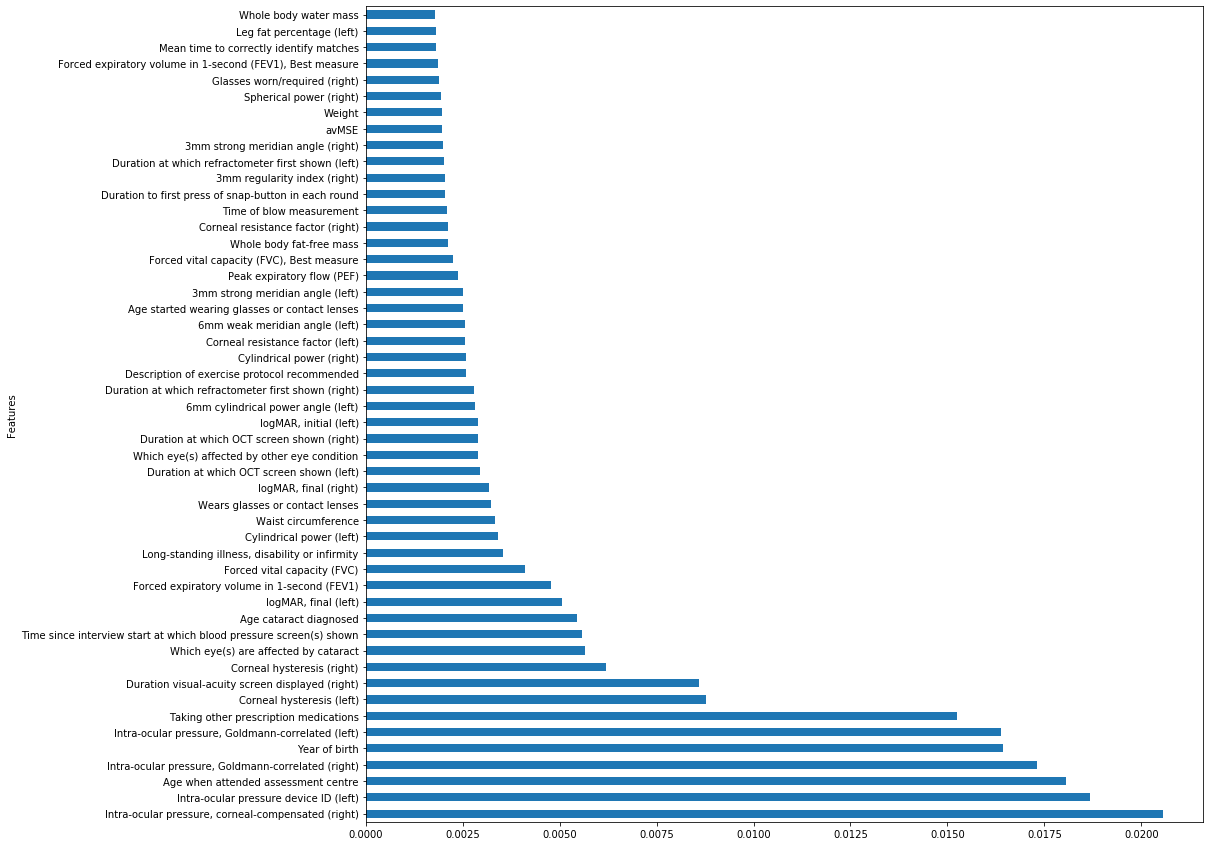

In [20]:
def plot_fi(finew):
    return finew.plot('Features','Importance','barh',figsize=(15,15),legend=False)

plot_fi(fi_red)

## Creating Dataframe containing important features

In [21]:
# Getting feature from feature description
feat_to_keep = fi_red[fi_red.Importance>0.0022].Features
featval_to_keep = []
for i in range(len(feat_to_keep)):
    for feat, desc in feat_unique_dict.items():    # for name, age in dictionary.iteritems():  (for Python 2.x)
        if desc == feat_to_keep[i]:
            featval_to_keep.append(feat)
            break
            
len(featval_to_keep)

35

In [22]:
meta_train_df.shape, meta_val_df.shape

((51438, 4898), (17146, 4898))

In [23]:
redtrain_df = meta_train_df.loc[:,meta_train_df.columns.str.startswith(featval_to_keep[0])]
for i in range(1,len(featval_to_keep)):
    redtrain_df = redtrain_df.join(meta_train_df.loc[:,meta_train_df.columns.str.startswith(featval_to_keep[i])])
    
redtrain_df.shape

(51438, 188)

In [24]:
redval_df = meta_val_df.loc[:,meta_val_df.columns.str.startswith(featval_to_keep[0])]
for i in range(1,len(featval_to_keep)):
    redval_df = redval_df.join(meta_val_df.loc[:,meta_val_df.columns.str.startswith(featval_to_keep[i])])
    
redval_df.shape

(17146, 188)

### Saving the dataframe

In [25]:
redtrain_df.to_pickle(tts_path + str(len(featval_to_keep))+'_features_union_train_df.pkl')
redval_df.to_pickle(tts_path + str(len(featval_to_keep))+'_features_union_val_df.pkl')

### Loading the dataframe

In [26]:
# LOAD
redtrain_df = pd.read_pickle(tts_path + str(len(featval_to_keep))+'_features_union_train_df.pkl')
redval_df = pd.read_pickle(tts_path + str(len(featval_to_keep))+'_features_union_val_df.pkl')
redtrain_df.shape, redval_df.shape

((51438, 188), (17146, 188))

#### without class_weight

In [27]:
rfc_red = RandomForestClassifier(n_estimators = 40, min_samples_leaf = 3, max_features = 0.5, n_jobs=-1, oob_score = True)
rfc_red.fit(redtrain_df, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=0.5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
                       oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [28]:
# Saving -- DONE !!
from sklearn.externals import joblib
joblib.dump(rfc_red, tts_path + 'RandomForest_redfeat_union.sav')

['/ds2/data/retina/UK_BB/patra/TrainTestVal/RandomForest_redfeat_union.sav']

#### with class weight

In [29]:
rfc_red_cw = RandomForestClassifier(bootstrap=True,
                                    class_weight=class_weight, criterion='gini',
                                    max_depth=8, max_features='auto', max_leaf_nodes=None,
                                    min_impurity_decrease=0.0, min_impurity_split=None,
                                    min_samples_leaf=4, min_samples_split=10,
                                    min_weight_fraction_leaf=0.0, n_estimators=300,
                                    n_jobs=-1, oob_score=True,
                                    verbose=0, warm_start=False)

rfc_red_cw.fit(redtrain_df, y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 35},
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=4,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=300, n_jobs=-1, oob_score=True,
                       random_state=None, verbose=0, warm_start=False)

### Loading Reduced features random forest

In [221]:
# rfc_red = joblib.load(tts_path + 'RandomForest_redfeat.sav')

In [30]:
# FEATURE DESCRIPTION DICTIONARY
feat_desc = pd.read_excel(DATA_dir + 'FeatureNames.xlsx')
feat_unique = feat_desc['UDI'].str.split('-',expand=True)[0].unique()
feat_desc_dict, feat_unique_dict = feature_desc()

In [31]:
feat_imp_dict, feat_unique_imp_dict = feature_imp(rfc_red_cw, redtrain_df)
fi_red = get_imp_features(40)
display_all(fi_red)

,Features,Importance
0,Year of birth,0.063680
1,"Intra-ocular pressure, corneal-compensated (right)",0.059869
2,Age when attended assessment centre,0.057554
3,"Intra-ocular pressure, Goldmann-correlated (right)",0.055271
4,Taking other prescription medications,0.053436
5,"Intra-ocular pressure, Goldmann-correlated (left)",0.048661
6,Corneal hysteresis (left),0.026466
7,Corneal hysteresis (right),0.023377
8,Duration visual-acuity screen displayed (right),0.021994
9,Time since interview start at which blood pressure screen(s) shown,0.016246


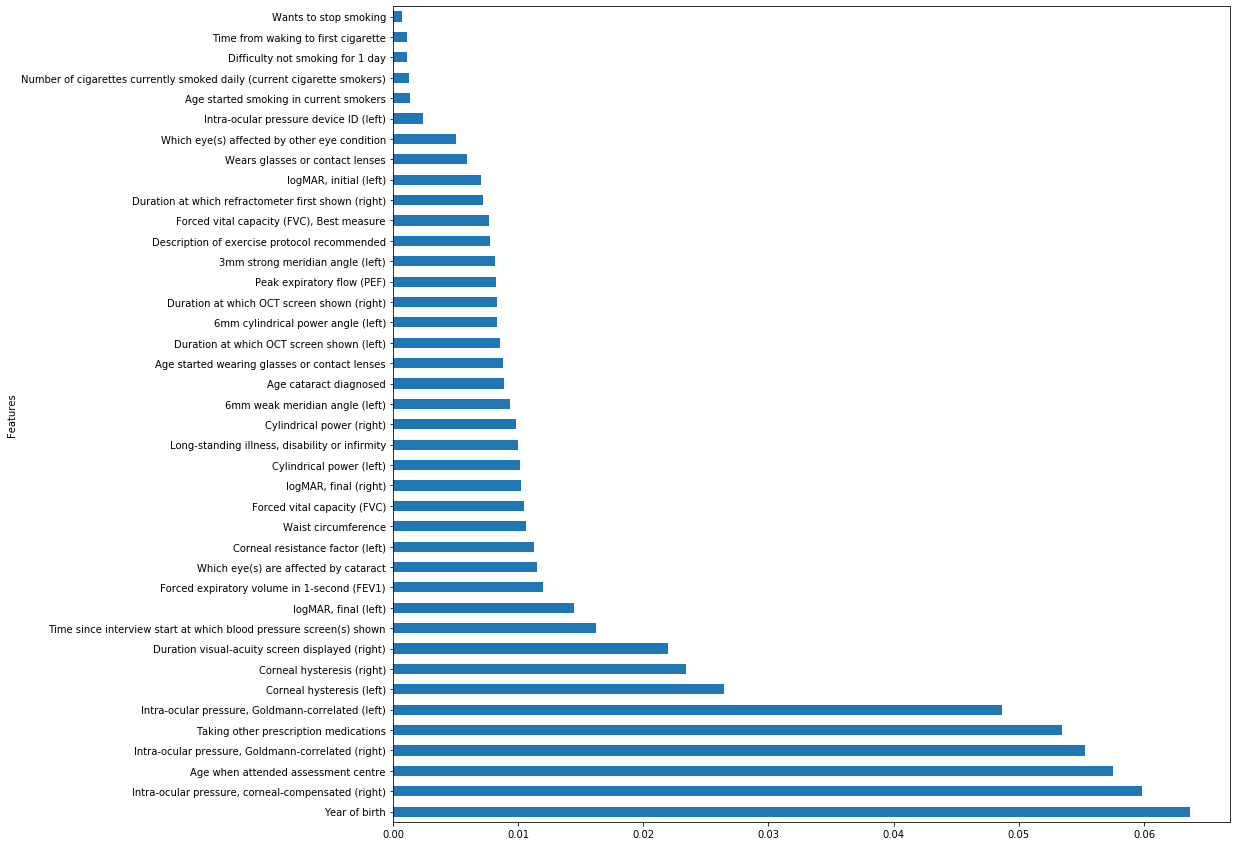

In [32]:
plot_fi(fi_red)

## Compare The Accuracy Of Full Feature Classifier To Limited Feature Classifier


In [33]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report, confusion_matrix

# Full Featured Classifier To The Test Data
y_pred = rfc_all_cw.predict(meta_val_df)
y_important_pred = rfc_red_cw.predict(redval_df)

#### F1 score

In [34]:
# 40 features
f1_score(y_val, y_pred) , f1_score(y_val, y_important_pred)

(0.13393359594822732, 0.15425131677953346)

#### Accuracy score

In [35]:
accuracy_score(y_val, y_pred) , accuracy_score(y_val, y_important_pred)

(0.9102414557331155, 0.8688907033710487)

#### Recall score

In [36]:
recall_score(y_val, y_pred) , recall_score(y_val, y_important_pred)

(0.25925925925925924, 0.4466230936819172)

#### Precision score

In [38]:
precision_score(y_val, y_pred) , precision_score(y_val, y_important_pred)

(0.09028831562974203, 0.09322419281491587)

#### classification_report

In [39]:
print(classification_report(y_val, y_pred) ,"\n\n", classification_report(y_val, y_important_pred))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95     16687
           1       0.09      0.26      0.13       459

    accuracy                           0.91     17146
   macro avg       0.53      0.59      0.54     17146
weighted avg       0.95      0.91      0.93     17146
 

               precision    recall  f1-score   support

           0       0.98      0.88      0.93     16687
           1       0.09      0.45      0.15       459

    accuracy                           0.87     17146
   macro avg       0.54      0.66      0.54     17146
weighted avg       0.96      0.87      0.91     17146



#### Confusion matrix

In [40]:
# tn, fp, fn, tp
print(confusion_matrix(y_val, y_pred) ,"\n\n", confusion_matrix(y_val, y_important_pred))

[[15488  1199]
 [  340   119]] 

 [[14693  1994]
 [  254   205]]


Healthy Patients - correctly identified (True Negatives):  15488 0.9281476598549769
Healthy Patients - predicted to have glaucoma (False Positives):  1199 0.07185234014502308
Glaucoma Patients - predicted healthy (False Negatives):  340 0.7407407407407407
Glaucoma Patients - correctly identified (True Positives):  119 0.25925925925925924

Total Glaucoma patients:  459 1.0
Total Healthy patients:  16687 1.0


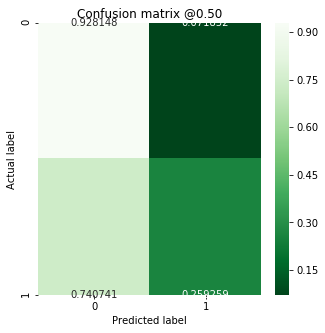

In [41]:
plot_cm(y_val, y_pred)